In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# create model

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def load_image(image_path):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)

    image = image.unsqueeze(0)
    return image

def predict(image_tensor, model):

    with torch.no_grad():
        output = model(image_tensor)
    o , predicted_idx = torch.max(output, 1)
    return predicted_idx.item()

# create indexFile.csv

In [5]:
import os
import pandas as pd

# Define the folder paths for vegetables
folder_path_vegetables = '.\images\\train'

# List of vegetable folders and their respective labels
vegetable_folders = [
    ('Bean', 0), 
    ('Bitter_Gourd', 1), 
    ('Bottle_Gourd', 2), 
    ('Brinjal', 3), 
    ('Broccoli', 4), 
    ('Cabbage', 5), 
    ('Capsicum', 6), 
    ('Carrot', 7), 
    ('Cauliflower', 8), 
    ('Cucumber', 9), 
    ('Papaya', 10), 
    ('Potato', 11), 
    ('Pumpkin', 12), 
    ('Radish', 13), 
    ('Tomato', 14)
]

# Collect the file paths and labels for all vegetable folders
all_data = []
for folder_name, label in vegetable_folders:
    folder_path = os.path.join(folder_path_vegetables, folder_name)
    files = os.listdir(folder_path)
    data = [(os.path.join(folder_path, file), label) for file in files]
    all_data.extend(data)

# Now `all_data` contains the file paths and labels for all vegetables
# print(all_data)

# Create a DataFrame
df = pd.DataFrame(all_data, columns=['Path', 'Label'])
# print(df)

df.to_csv("train_indexFile.csv", index=False, index_label=False)


In [6]:
# Define the folder paths for vegetables
folder_path_vegetables = '.images\\validation'

# List of vegetable folders and their respective labels
vegetable_folders = [
    ('Bean', 0), 
    ('Bitter_Gourd', 1), 
    ('Bottle_Gourd', 2), 
    ('Brinjal', 3), 
    ('Broccoli', 4), 
    ('Cabbage', 5), 
    ('Capsicum', 6), 
    ('Carrot', 7), 
    ('Cauliflower', 8), 
    ('Cucumber', 9), 
    ('Papaya', 10), 
    ('Potato', 11), 
    ('Pumpkin', 12), 
    ('Radish', 13), 
    ('Tomato', 14)
]

# Collect the file paths and labels for all vegetable folders
all_data = []
for folder_name, label in vegetable_folders:
    folder_path = os.path.join(folder_path_vegetables, folder_name)
    files = os.listdir(folder_path)
    data = [(os.path.join(folder_path, file), label) for file in files]
    all_data.extend(data)

# Now `all_data` contains the file paths and labels for all vegetables
# print(all_data)

# Create a DataFrame
df = pd.DataFrame(all_data, columns=['Path', 'Label'])
# print(df)

df.to_csv("val_indexFile.csv", index=False, index_label=False)

# custom dataset

In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx, 0]  # Get the image path
        image = Image.open(img_path).convert("RGB")  # Load image

        label = self.data_frame.iloc[idx, 1]  # Get the label

        if self.transform:
            image = self.transform(image)  # Apply transformations if any

        return image, label

# get pre-trained weight and freeze feature extraction of model

In [8]:
tmp = models.vgg16(pretrained=True)

vgg16 = VGG()
vgg16.load_state_dict(tmp.state_dict())

vgg16.to(device)

# change the number of classes 
vgg16.classifier[6].out_features = 3
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 214MB/s] 


In [9]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch = 256

trainset = CustomImageDataset(csv_file = "train_indexFile.csv", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True)
testset = CustomImageDataset(csv_file = "val_indexFile.csv", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False)

In [10]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

# loss function
criterion = nn.CrossEntropyLoss()

# train model

In [11]:
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [12]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [13]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(5):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0130, Train Acc: 52.13
Train Loss: 0.0010, Train Acc: 92.79
Train Loss: 0.0006, Train Acc: 95.89
Train Loss: 0.0004, Train Acc: 97.06
Train Loss: 0.0003, Train Acc: 97.83
13.295242846012115 minutes


# accuracy graph

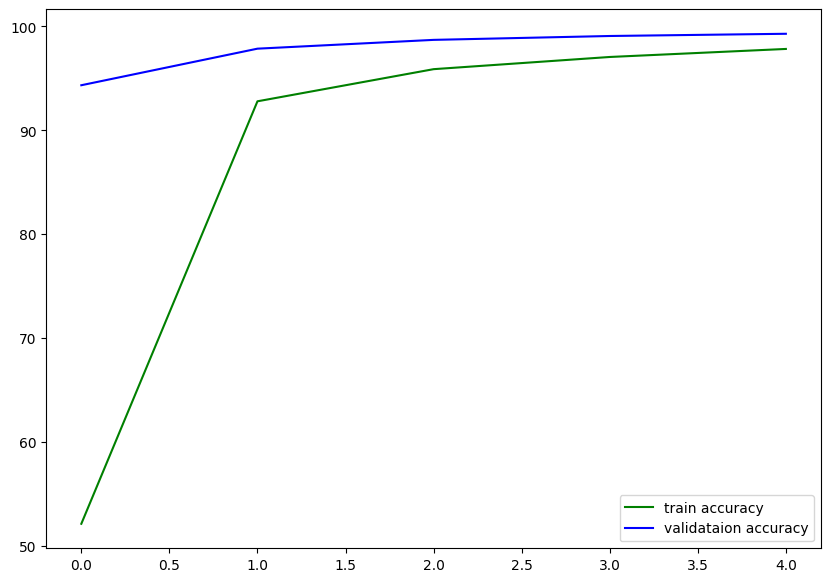

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

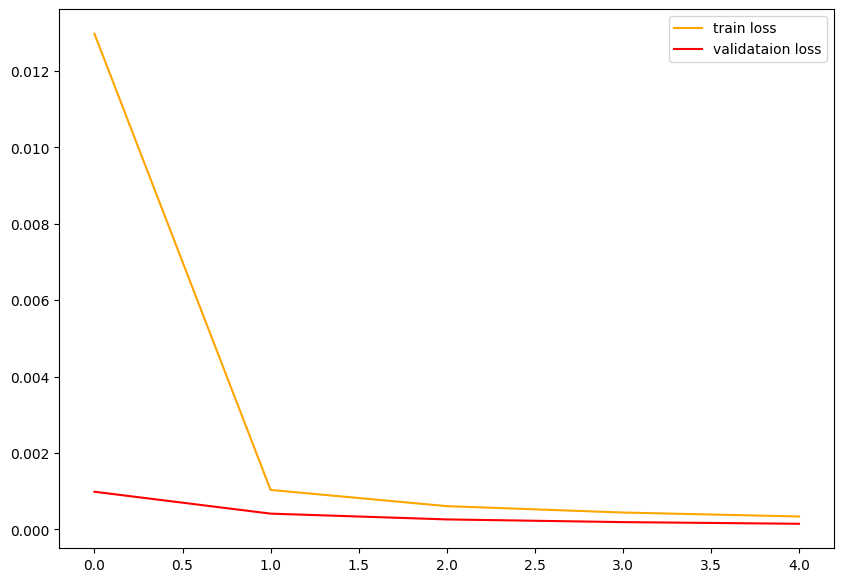

In [15]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [16]:
image_path = ".\images\\test\Tomato\\1208.jpg"
image_tensor = load_image(image_path)
print(image_tensor.shape)
predicted_class = predict(image_tensor.to(device), vgg16)

print(f"Predicted class: {predicted_class}")

torch.Size([1, 3, 224, 224])
Predicted class: 14
